# S21 simulation and fitting of a resonator

Authors: Samarth Hawaldar, Arvind Mamgain

Adapted from tutorial 4.16


In [1]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
# Analysis
# from qiskit_metal.renderers.renderer_gds.gds_renderer import QGDSRenderer
# from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping
import pyEPR as epr

In [2]:
import numpy as np

# Set up the design

In [3]:
# Set up chip dimensions 
design = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '9mm'
design._chips['main']['size']['size_y'] = '9mm'
design._chips['main']['size']['size_z'] = '-280um'
# Resonator and feedline gap width (W) and center conductor width (S) from reference 2
design.variables['cpw_width'] = '10 um' #S from reference 2
design.variables['cpw_gap'] = '6 um' #W from reference 2


design.overwrite_enabled = True

hfss = design.renderers.hfss

# Open GUI
gui = MetalGUI(design)

In [4]:
# Define for renderer
eig_qres = EPRanalysis(design, "hfss")
#hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# Define the geometry

Here we will have a single feedline couple to a single CPW resonator.

The lauchpad should be included in the driven model simulations.

For that reason, we use the LaunchpadWirebondDriven component which has an extra pin for input/output

In [5]:
###################
# Single feedline #
###################

# Driven Lauchpad 1
x = '-0.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='360', lead_length='30um')
LP1 = LaunchpadWirebondDriven(design, 'LP1', options = launch_options)

# Driven Launchpad 2
x = '0.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='180', lead_length='30um')
LP2 = LaunchpadWirebondDriven(design, 'LP2', options = launch_options)

# coupling resonator to feedline 
q_read = CoupledLineTee(design,'Q_Read_T', options=dict(pos_x = '0.0mm', pos_y = '2mm', 
                                                        orientation = '0',
                                                        coupling_space = '6um',                                                         
                                                        coupling_length = '300um',
                                                        open_termination = False))


gui.rebuild()


In [6]:

# Using path finder to connect the two launchpads
TL_LP1_T = RoutePathfinder(design, 'TL_LP1_T', options = dict(chip='main', trace_width ='10um',
        trace_gap ='6um',
                                            fillet='99um',
                                                                  
        hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='Q_Read_T',
                                                    pin='prime_start')
                                            )))

TL_T_LP2 = RoutePathfinder(design, 'TL_T_LP2', options = dict(chip='main', trace_width ='10um',
        trace_gap ='6um',
                                            fillet='99um',
                                                                  
        hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_Read_T',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))
# # Rebuild the GUI

In [7]:
######################
# lambda/4 resonator #
######################

# First we define the two end-points
otg = OpenToGround(design, 'otg', options=dict(chip='main', pos_x='0.0mm',  pos_y='0.8mm', orientation='-90'))

# Use RouteMeander to fix the total length of the resonator
rt_meander = RouteMeander(design, 'meander',  Dict(
        trace_width ='10um',
        trace_gap ='6um',
        total_length='3.7mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg', pin='open'),
            end_pin=Dict(component='Q_Read_T', pin='second_end')), ))

# rebuild the GUI
gui.rebuild()

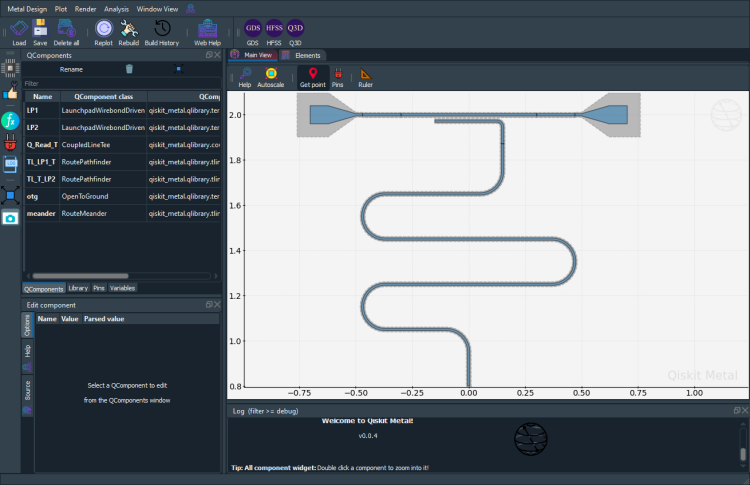

In [8]:
gui.autoscale()
gui.screenshot()

# Scattering Analysis

In [27]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [28]:
design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin LP1_in and LP2_in are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('LP1', 'in', 50),
             ('LP2', 'in', 50)]
box_plus_buffer = True

In [47]:
em1.setup.name = "Sweep_DrivenModal_setup"
em1.setup.freq_ghz = 6.0 # Try to keep this at the center of the swept frequency range for 'fast' sweeps and at the largest frequency for interpolating sweep for the best results
em1.setup.max_delta_s = 0.005 # This is necessary to get good results if interpolating sweep is not working for you
em1.setup.max_passes = 18
em1.setup.min_passes = 2
em1.setup.basis_order = -1 # Mixed order
em1.setup

{'name': 'Sweep_DrivenModal_setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 6.0,
 'max_delta_s': 0.005,
 'max_passes': 18,
 'min_passes': 2,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': -1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 4.0,
  'stop_ghz': 8.0,
  'count': 10001,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

In [30]:
# we use HFSS as rendere
hfss = em1.renderer
hfss.start()

INFO 10:38AM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:38AM [load_ansys_project]: 	Opened Ansys App
INFO 10:38AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 10:38AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/QTLAB/Kunal/OneDrive - Indian Institute of Science/Documents/Ansoft/Directory/
	Project:   Project7
INFO 10:38AM [connect_design]: 	Opened active design
	Design:    Design_hfss [Solution type: DrivenModal]
INFO 10:38AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:38AM [connect]: 	Connected to project "Project7" and design "Design_hfss" 😀 



True

In [31]:
# set buffer
hfss.options['x_buffer_width_mm'] = 0.1
hfss.options['y_buffer_width_mm'] = 0.1

In [32]:
# clean the design if needed
hfss.clean_active_design()

In [42]:
# render the design
em1._render(selection=[],
                    solution_type='drivenmodal',
                    vars_to_initialize=em1.setup.vars, 
                    open_pins=open_terminations, 
                    port_list=port_list, 
                    box_plus_buffer = box_plus_buffer)

INFO 10:42AM [connect_design]: 	Opened active design
	Design:    Design_hfss [Solution type: DrivenModal]


'Design_hfss'

In [48]:
#for accurate simulations, make sure the mesh is fine enough for the meander
hfss.modeler.mesh_length(
                'cpw_mesh',
                ['trace_meander'],
                MaxLength='0.05mm')

# Broad sweet to find the resonance

In [49]:
em1.setup.sweep_setup.start_ghz = 4.0
em1.setup.sweep_setup.stop_ghz = 8.0
em1.setup.sweep_setup.count = 10001
em1.setup.sweep_setup.type = "Fast"
em1._analyze() # This is necessary to keep the changes made to max_delta_s and min_passes

INFO 10:45AM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:45AM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:45AM [analyze]: Analyzing setup Sweep_DrivenModal_setup : Sweep


In [50]:
hfss.plot_params(['S21'])
# make sure that you can see a dip in S21. If not, change the frequency sweep region or decrease the MaxLength of the mesh and retry.
# Or you can even try an interpolating sweep

(                       S11                 S21
 4.0000 -0.000222-0.000797j -0.944088+0.329694j
 4.0004 -0.000223-0.000797j -0.944077+0.329725j
 4.0008 -0.000223-0.000797j -0.944065+0.329757j
 4.0012 -0.000223-0.000797j -0.944054+0.329789j
 4.0016 -0.000223-0.000798j -0.944043+0.329821j
 ...                    ...                 ...
 7.9984 -0.002487-0.003344j -0.782896+0.622139j
 7.9988 -0.002487-0.003345j -0.782875+0.622166j
 7.9992 -0.002488-0.003345j -0.782854+0.622192j
 7.9996 -0.002488-0.003345j -0.782833+0.622218j
 8.0000 -0.002488-0.003345j -0.782812+0.622245j
 
 [10001 rows x 2 columns],
 <Figure size 1000x600 with 2 Axes>)

In [51]:
hfss.get_convergences() # Make sure that it converges

  df = pd.read_csv(io.StringIO(text2[3].strip()),



(             Solved Elements  Max Mag. Delta S
 Pass Number                                   
 1                       9546               NaN
 2                      12416          0.534770
 3                      14280          0.231140
 4                      18110          0.122500
 5                      22027          0.047919
 6                      27371          0.022561
 7                      35530          0.014636
 8                      46150          0.008065
 9                      59906          0.005799
 10                     77821          0.005072
 11                    101114          0.003759,
 None,
 "DesignVariation : Cj='0fF' Lj='10nH'\nSetup : Sweep_DrivenModal_setup\n\n==================\nNumber of Passes\nCompleted : 11\nMaximum   : 18\nMinimum   : 2\n==================\nCriterion : Max Mag. Delta S\nTarget    : 0.005\nCurrent   : 0.0037588\nTarget Consecutive Passes  : 1\nCurrent Consecutive Passes : 1\nConverged : Yes\n==================\nPass Number|Sol

In [52]:
# extract the S21 parameters
freqs, Pcurves, Pparams = hfss.get_params(['S21'])
# find argmin 
f_res = freqs[np.argmin(np.abs(Pparams.S21.values))]
f_res # If the dip at f_res is not deep enough to be the minimum in the plot, try to eyeball its location and set it here. A better way would be to use scipy's find_peaks functionality

# Narrow sweep around the resonance found above

In [55]:
em1.setup.sweep_setup.start_ghz = np.round(f_res/1e9,5)-0.05
em1.setup.sweep_setup.stop_ghz = np.round(f_res/1e9,5)+0.05
em1._analyze()

INFO 10:48AM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:48AM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:48AM [analyze]: Analyzing setup Sweep_DrivenModal_setup : Sweep


In [58]:
hfss.plot_params(['S21'])

(                        S21
 6.37160 -0.856579+0.515993j
 6.37161 -0.856578+0.515995j
 6.37162 -0.856577+0.515997j
 6.37163 -0.856576+0.515999j
 6.37164 -0.856574+0.516001j
 ...                     ...
 6.47156 -0.859590+0.510894j
 6.47157 -0.859589+0.510896j
 6.47158 -0.859588+0.510898j
 6.47159 -0.859587+0.510900j
 6.47160 -0.859586+0.510902j
 
 [10001 rows x 1 columns],
 <Figure size 1000x600 with 2 Axes>)

In [59]:
freqs, Pcurves, Pparams = hfss.get_params(['S21'])

In [62]:
# find argmin
f_res = freqs[np.argmin(np.abs(Pparams.S21.values))]
f_res

6421660000.0

# Very-Narrow sweep around the resonance found above

In [64]:
em1.setup.sweep_setup.start_ghz = np.round(f_res/1e9,5)-0.005
em1.setup.sweep_setup.stop_ghz = np.round(f_res/1e9,5)+0.005
em1._analyze()

INFO 10:51AM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:51AM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:51AM [analyze]: Analyzing setup Sweep_DrivenModal_setup : Sweep


In [65]:
hfss.plot_params(['S21'])

(                         S21
 6.416660 -0.817559+0.571696j
 6.416661 -0.817550+0.571707j
 6.416662 -0.817541+0.571718j
 6.416663 -0.817532+0.571729j
 6.416664 -0.817523+0.571740j
 ...                      ...
 6.426656 -0.889979+0.449985j
 6.426657 -0.889973+0.449998j
 6.426658 -0.889968+0.450011j
 6.426659 -0.889962+0.450025j
 6.426660 -0.889957+0.450038j
 
 [10001 rows x 1 columns],
 <Figure size 1000x600 with 2 Axes>)

In [66]:
freqs, Pcurves, Pparams = hfss.get_params(['S21'])

In [67]:
from qiskit_metal.analyses.em.transmission_fitting import fit_transmission

({'amplitude_complex': (-0.8175586777425192+0.5716957692308889j),
  'Qr': 9781.637982450446,
  'Qc': 9803.308924811008,
  'fr': 6421661392.182717,
  'phi0': 0.0023751896111647887,
  'delay': -2.2608224767586054e-09},
 [<Figure size 1280x960 with 3 Axes>,
  array([<AxesSubplot:xlabel='Freq (Hz)', ylabel='|S21|'>,
         <AxesSubplot:xlabel='Freq (Hz)', ylabel='arg(S21)'>,
         <AxesSubplot:xlabel='Re(S21)', ylabel='Im(S21)'>], dtype=object)])

In [ ]:
fit_transmission(freqs,Pparams.S21.values) # This fits the transmission, plots the fit over the raw data, and returns only the parameters best fit parameters and plots

In [ ]:
# This fits the transmission, but does not generate the plot. Also, returns the fit parameters as a vector and the associated covariance matrix
fit_dict, _, fit_vec, fit_cov = fit_transmission(freqs,Pparams.S21.values, full_output=True, plot=False)

# To obtain the standard deviations from the covariance matrix, use the below
np.sqrt(np.diag(fit_cov))

# Close connections

In [37]:
#from qiskit_metal import q13

In [68]:
em1.close()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [69]:
hfss.disconnect_ansys()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [40]:
#gui.main_window.close()